In [267]:
# MINIMIZING AVG PAIRWISE DIST

In [280]:
import sys
print(sys.executable)
!{sys.executable} -m pip install gurobipy
from gurobipy import *
import math
from matplotlib import pyplot as plt

/Users/Abe/opt/anaconda3/bin/python


In [269]:
#open jld
#https://docs.h5py.org/en/stable/high/group.html
#https://docs.h5py.org/en/stable/high/attr.html
import h5py
x1_data = h5py.File("X1.jld", "r")
x2_data = h5py.File("X2.jld", "r")
x3_data = h5py.File("X3.jld", "r")

#print(x1_data.keys(),x2_data.keys(),x3_data.keys())

# f["input"].value, f["output"].value
# f["X"].value
# f["_creator"]

print(x1_data["X"])
print(x1_data["X"][0])
print(x1_data["X"][1])

#x1_data["_creator"].keys()

<HDF5 dataset "X": shape (2, 25), type "<f8">
[-9.31431352 -5.66901261 -5.58994131 -6.48529461 -4.64803558 -6.92318026
 -4.9219469  -6.18895012 -6.383588   -4.83052083 -5.54884829 -6.03902456
 -9.36696392 -1.01326107  0.08758034  1.34522284  1.02763538  0.18065355
  0.96876053  2.14521255 -3.81989054 -4.94544952 -3.29144358 -2.36855237
 -4.05178677]
[ 21.85248196  22.82571229  21.70189592  20.44812788 -13.57047711
 -13.45455931 -13.16898973 -15.16087729 -14.11121926 -13.3698081
 -13.74643136 -13.17614957 -13.63194927  -5.99053048  -4.86670161
  -5.53625377  -6.47446421  -4.69903272  -4.01117971  -6.54907345
   1.50498652   1.28581208   2.7638501    2.11314414   1.67859478]


In [270]:
#Set parameters

instance = 2
# 1 or 2 (3 not feasible)

if instance == 1:
    n_min = 2
    n_max = 8
    d_max = 10
    X = [x1_data["X"][0], x1_data["X"][1]]
    
elif instance == 2:
    n_min = 4
    n_max = 6
    d_max = 9
    X = [x2_data["X"][0], x2_data["X"][1]]

else:
    print("Error: instance needs to be 1 or 2")

n = len(x1_data["X"][0]) #should be 25

In [271]:
# Define a distance matrix to hopefully reduce computational intensity
# D[i][ii] is the distance between clients i and ii

D = []
for i in range(len(clients)):
    D.append([])
    for ii in range(len(clients)):
        D[i].append( math.sqrt((X[0][i] - X[0][ii])**2 + (X[1][i] - X[1][ii])**2) )
max(D[1])

22.18458855699755

In [272]:
# create model
myModel = Model( "ClientDepot_MinDist" )

In [273]:
# decision variables and parameters

# Y is an assignment matrix:
# Y[i][j] = 1: client i is assigned to depot j, otherwise 0
# each entry of Y is its own decision variable
Y = []
for i in range(n):
    Y.append([])
    for j in range(n):
        Y[i].append(0)
        Y[i][j] = myModel.addVar(lb = 0, ub = 1.0, vtype = GRB.BINARY )


#depots is a vector that indicates whether a depot has clients assigned to it
#depots[j] = 0: no clients assigned to depot j.
#          = 1: one or more clients assigned to depot j.
depots = [myModel.addVar(lb = 0, ub = 1.0, vtype = GRB.BINARY ) for j in range(n)]

#parallel (perpendicular?) list to depots, used just for summing 
clients = [None for j in range(n)] 

# Z is a matrix that indicates whether clients i and ii are in the same depot
Z = []
for i in range(len(clients)):
    Z.append([])
    for ii in range(len(clients)):
        Z[i].append(None)
        Z[i][ii] = myModel.addVar(lb = 0, ub = 1.0, vtype = GRB.CONTINUOUS )


#Y = myModel.addVar( vtype = GRB.BINARY, name = "Y" )
myModel.update()
#print(Y)
        

In [274]:
# objective: MINIMIZE PARIWISE DISTANCE

# find an expression for total pairwise distance, 
# then select only the pairs that are in the same cluster.

objExpr = LinExpr()

for i in range(len(clients)):
    for ii in range(len(clients)):
        
        objExpr += D[i][ii]*Z[i][ii]/2
        #divide by 2 since this will double count

myModel.setObjective( objExpr , GRB.MINIMIZE )

In [275]:
# create expressions for constraints and add to the model

#ZEROTH CONSTRAINT: definition of Z
#matrix that indicates whether two clients are in the same depot

for j in range(len(depots)):
    
    for i in range(len(clients)):
        for ii in range(len(clients)):
        
            myModel.addConstr( lhs = Z[i][ii] , sense = GRB.LESS_EQUAL , rhs = ( Y[i][j] + Y[ii][j] ) / 2 + 0.1)
            #Y[i][j] + Y[ii][j] ) / 2
            # if Y[i][j] and Y[ii][j] are not both 1, then Z[i][ii] is constrained to be less than 1 (so zero)
            # Otherwise this constraint is satisfied by any value of Z[i][ii]
            
            myModel.addConstr( lhs = Z[i][ii] , sense = GRB.GREATER_EQUAL , rhs = Y[i][j] + Y[ii][j] - 1.9) 
            #Y[i][j] + Y[ii][j] - 1
            # if Y[i][j] and Y[ii][j] are both 1, then Z[i][ii] >= 0.5, so it will be 1. 
            # Otherwise this constraint is satisfied by any value of Z[i][ii]
            
            

# FIRST CONSTRAINT: definition of "depots" 
#(vector that indicates if a column of Y represents a depot)

firstConst = [LinExpr() for j in depots]
for j in range(len(depots)):
    
    for i in range(len(clients)):
        firstConst[j] += Y[i][j]/(n+1)
    
    # 0 < firstConst[j] < 1 if there is at least 1 client assigned to depot j
        
    myModel.addConstr( lhs = depots[j] , sense = GRB.GREATER_EQUAL , rhs = firstConst[j] )
    #if there are some clients assigned to depot j (nonzero entries in the j-th col of Y)
    #then depots[j] must be non-zero. since depots is binary, it will take on the value 1.
    
    myModel.addConstr( lhs = depots[j], sense = GRB.LESS_EQUAL, rhs = firstConst[j]*(n+1) + 0.5 )
    # if there is no client assigned to depots[j], then the rhs will be 0.5, so
    # depots[j] will be forced to be less than 0.5, and the only option is zero
    # NOTE that this contraint is automatically satisfied if firstConst[j] is nonzero since the lhs > 1.
    
    
    
#SECOND CONSTRAINT: client-depot uniqueness
#ensures that the sum of each row of Y is exactly 1 (each client assigned to one unique depot)

secondConst = [LinExpr() for i in clients]
for i in range(len(clients)):
    
    for j in range(len(depots)):
        secondConst[i] += Y[i][j]
    
    myModel.addConstr( lhs = secondConst[i] , sense = GRB.EQUAL , rhs = 1 )

    
#THIRD CONSTRAINT: min and max clients constraint

thirdConst = [LinExpr() for j in depots]
for j in range(len(depots)):
    
    for i in range(len(clients)):
        thirdConst[j] += Y[i][j]
    
    myModel.addConstr( lhs = thirdConst[j] , sense = GRB.LESS_EQUAL , rhs = n_max*depots[j] )
    myModel.addConstr( lhs = thirdConst[j] , sense = GRB.GREATER_EQUAL , rhs = n_min*depots[j] )
    
# FOURTH CONSTRAINT: max distance constraint

for j in range(len(depots)):
    
    #compare the distances between all clients in the column
    
    for i in range(len(depots)):
        for ii in range(len(depots)): #TRIPLE LOOP :)
            
            act = 100*(1 - Y[i][j]) + 100*(1 - Y[ii][j]) #100 is about 5x the max distance 
            myModel.addConstr( lhs = D[i][ii] , sense = GRB.LESS_EQUAL , rhs = d_max + act )
            #if Y[i][j] or Y[ii][j] = 0, the constraint will be satisfied automatically
            #if they are both 1, then the constraint is "act"ivated, 
            #so the distance between that pair must be less than d_max
            

In [276]:
# integrate objective and constraints into the model
myModel.update()
# write the model in a file to make sure it is constructed correctly
myModel.write( filename = "testOutput_C.lp" )
# optimize the model
myModel.optimize()

Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 47000 rows, 1275 columns and 126350 nonzeros
Model fingerprint: 0xd4143991
Variable types: 625 continuous, 650 integer (650 binary)
Coefficient statistics:
  Matrix range     [4e-02, 2e+02]
  Objective range  [4e-01, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-01, 2e+02]
Presolve removed 40177 rows and 445 columns
Presolve time: 0.14s
Presolved: 6823 rows, 830 columns, 28230 nonzeros
Variable types: 0 continuous, 830 integer (830 binary)

Root relaxation: objective 0.000000e+00, 1094 iterations, 0.06 seconds (0.13 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000    0   67          -    0.00000      -     -    0s
H    0     0                      14.5550193    0.00000   

In [277]:
# print optimal objective and optimal solution
print( "\nOptimal Objective: " + str( myModel.ObjVal ) )

print( "\nOptimal Solution:" )
Y_vals = []
for i in range(len(clients)):
    Y_vals.append([])
    for j in range(len(depots)):
        Y_vals[i].append(int(Y[i][j].x))

for i in range(len(clients)):
    print(Y_vals[i])


Optimal Objective: 12.050819192152407

Optimal Solution:
[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [278]:
# Grab the indices of the clusters:
depots_vals = [int(val.x) for val in depots]

def clusters(assign_matrix):
    clusts = []
    
    for j in range(len(depots_vals)):
        
        if depots_vals[j] == 1: #check if the col of Y is a depot
            
            clusts.append([])
            for i in range(len(clients)):
                
                if assign_matrix[i][j] == 1:
                     clusts[-1].append(i)
    
    return clusts

clusters(Y_vals)

[[0, 9, 18, 23], [10, 11, 17], [16, 19, 20], [2, 14, 22, 24], [], [5]]

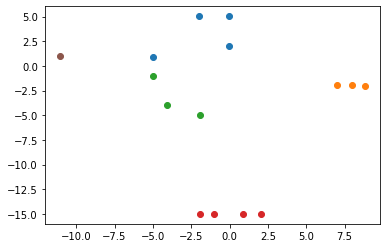

In [281]:
# Create scatterplot


c = clusters(Y_vals)

X_colors_0 = []
for i in range(len(c)):
    X_colors_0.append([])
    
    for index in c[i]:
        X_colors_0[i].append(X[0][index])

        
X_colors_1 = []
for i in range(len(c)):
    X_colors_1.append([])
    
    for index in c[i]:
        X_colors_1[i].append(X[1][index])
       
        
for i in range(len(X_colors_1)):
    
    plt.scatter(X_colors_0[i], X_colors_1[i])   